a-Si 512 atom, getting eigenvector and frequency based on phonopy, then evaluate dynamic structure factor

In [24]:
import numpy as np
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from ase.io import read

atoms=read('optimized.vasp',format='vasp')



In [25]:
unitcell = PhonopyAtoms(symbols=atoms.symbols,
                    cell=atoms.cell,
                    positions=atoms.positions)
phonon = Phonopy(unitcell,
                [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                primitive_matrix=[[1,0,0],[0,1,0],[0,0,1]],log_level=1)

In [26]:
import pyAF.data_parse
FC_file='FORCE_CONSTANTS_2ND'
natom=len(atoms.positions)
#read as ndarray, no mass scaling here
fc_phonopy=pyAF.data_parse.read_fc_phonopy_noscale(FC_file,natom)

In [27]:
fc_phonopy.shape

(512, 512, 3, 3)

In [28]:
phonon.set_force_constants(fc_phonopy)
phonon.symmetrize_force_constants(show_drift=True)
symetrized_fc=phonon.force_constants

Max drift of force constants: -0.000000 (zx) -0.000000 (xz)
Max drift after symmetrization by translation: 0.000000 (xx) 0.000000 (xx)


In [29]:
#getting eigenvector and freq at k=0

mesh = [1, 1, 1]
phonon.run_mesh(mesh,with_eigenvectors=True)
mesh_dict = phonon.get_mesh_dict()
frequencies = mesh_dict['frequencies']
eigenvectors =mesh_dict['eigenvectors']

In [30]:
frequencies.shape, eigenvectors.shape

((1, 1536), (1, 1536, 1536))

phonopy yaml format: Eigenvector at each phonon mode. Each eigenvector e of dynamical matrix is shown as sets of three complex values of each atom along the Cartesian axes in the primitive cell. The real and imaginary values correspond to the left and right, respectively. A set of eigenvectors comprising all bands at a q-point forms a unitary matrix obtained as the result of numpy.linalg.eigh, i.e., LAPACK of routine _heevd. Therefore eigenvectors correspond to the column vectors of the unitary matrix.

Eigenvectors corresponding to phonopy yaml output are obtained as follows.
```
if eigvecs is not None:
    for eigvecs_at_q in eigvecs:
        for vec in eigvecs_at_q.T:
            print vec
```

In [31]:
from tqdm import tqdm

eigenvectors=eigenvectors.squeeze(0)

kmin=2.0*np.pi/atoms.cell[0,0]
kmax=kmin*10
kvec=np.linspace(kmin,kmax,10)
n_kpt=len(kvec)
import pyAF.postprocess
n_sample=10
n_modes=natom*3
C_L=np.zeros((n_kpt,n_modes))
C_T=np.zeros((n_kpt,n_modes))
position=atoms.positions
nmodes=natom*3

for ik,k in enumerate(tqdm(kvec)):

    for imode in range(nmodes):
        ev=eigenvectors[:,imode]
        cl, ct=pyAF.postprocess.get_Ci_ver3(ev,position,k)
        C_L[ik,imode]=cl
        C_T[ik,imode]=ct



100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [32]:
import pyAF.constants

eigenvalue=frequencies.squeeze(0)

pc=pyAF.constants.physical_constants()
omega=[]
nmodes=len(eigenvalue)
#extract minimum index of negative frequency
mode_negative=0
for i in range(nmodes):
    if eigenvalue[i] <0.0:
        val=0
        omega.append(val)
        mode_negative=i
    else:
        omega.append(eigenvalue[i])

Plot the results

Transverse mode

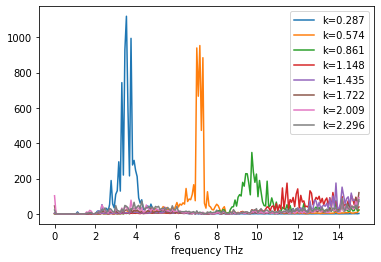

In [33]:
mesh_energy=np.linspace(0,15,200)


import pyAF.postprocess
dsf_L, dsf_T=pyAF.postprocess.dynamic_structure_factor(C_L=C_L, C_T=C_T, mesh_energy=mesh_energy, frequency=omega, smearing=0.005)

import matplotlib.pyplot as plt
plt.plot(mesh_energy,dsf_L[0,:],label='k={0:.3f}'.format(kvec[0]))
plt.plot(mesh_energy,dsf_L[1,:],label='k={0:.3f}'.format(kvec[1]))
plt.plot(mesh_energy,dsf_L[2,:],label='k={0:.3f}'.format(kvec[2]))
plt.plot(mesh_energy,dsf_L[3,:],label='k={0:.3f}'.format(kvec[3]))
plt.plot(mesh_energy,dsf_L[4,:],label='k={0:.3f}'.format(kvec[4]))
plt.plot(mesh_energy,dsf_L[5,:],label='k={0:.3f}'.format(kvec[5]))
plt.plot(mesh_energy,dsf_L[6,:],label='k={0:.3f}'.format(kvec[6]))
plt.plot(mesh_energy,dsf_L[7,:],label='k={0:.3f}'.format(kvec[7]))

plt.xlabel('frequency THz')
plt.legend()


Longitudinal mode

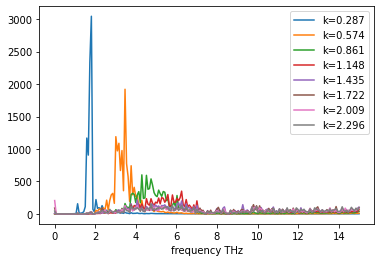

In [35]:
import matplotlib.pyplot as plt
plt.plot(mesh_energy,dsf_T[0,:],label='k={0:.3f}'.format(kvec[0]))
plt.plot(mesh_energy,dsf_T[1,:],label='k={0:.3f}'.format(kvec[1]))
plt.plot(mesh_energy,dsf_T[2,:],label='k={0:.3f}'.format(kvec[2]))
plt.plot(mesh_energy,dsf_T[3,:],label='k={0:.3f}'.format(kvec[3]))
plt.plot(mesh_energy,dsf_T[4,:],label='k={0:.3f}'.format(kvec[4]))
plt.plot(mesh_energy,dsf_T[5,:],label='k={0:.3f}'.format(kvec[5]))
plt.plot(mesh_energy,dsf_T[6,:],label='k={0:.3f}'.format(kvec[6]))
plt.plot(mesh_energy,dsf_T[7,:],label='k={0:.3f}'.format(kvec[7]))

plt.xlabel('frequency THz')
plt.legend()